In [1]:
import sys
sys.path.append(".")
# also disable grad to save memory
import torch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.__version__)
print(torch.version.cuda)
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

cuda:0
1.11.0
11.3


In [2]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))

In [3]:
# develop dataset
from torch.cuda.amp import autocast
from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

df_train = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/hbi/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/hbi/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/hbi/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(dataset_train), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size=1, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size=1, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=8),
          }

32183 3493 3560


In [22]:
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from nuwa_pytorch.nuwa_pytorch import top_k, gumbel_sample
import random

In [4]:
import torch
from nuwa_pytorch import VQGanVAE
from nuwa_pytorch.optimizer import get_optimizer
vae = VQGanVAE(
    dim = 256,
    channels = 1,               # default is 3, but can be changed to any value for the training of the segmentation masks (sketches)
    image_size = 256,           # image size
    num_layers = 4,             # number of downsampling layers
    num_resnet_blocks = 2,      # number of resnet blocks
    vq_codebook_size = 1024,    # codebook size
    vq_decay = 0.8 ,             # codebook exponential decay
    use_hinge_loss = True,
    use_vgg_and_gan = True
).to(DEVICE)
checkpoint = torch.load('/bulk/junzheyin/aaa/vae_epoch80', map_location = 'cpu')
vae.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

In [12]:
import torch
from nuwa_pytorch import VQGanVAE
from nuwa_pytorch.optimizer import get_optimizer
vae = VQGanVAE(
    dim = 256,
    channels = 1,               # default is 3, but can be changed to any value for the training of the segmentation masks (sketches)
    image_size = 256,           # image size
    num_layers = 4,             # number of downsampling layers
    num_resnet_blocks = 2,      # number of resnet blocks
    vq_codebook_size = 1024,    # codebook size
    vq_decay = 0.8 ,             # codebook exponential decay
    use_hinge_loss = True,
    use_vgg_and_gan = True
).to(DEVICE)
checkpoint = torch.load('/home/hbi/vae_epoch80', map_location = 'cpu')
vae.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

In [13]:
print(vae.codebook.size())

torch.Size([1024, 256])


: 

In [5]:
pcc_sum = [0]*6
mse_sum = [0]*6
mae_sum = [0]*6
csi1_sum = [0]*6
csi2_sum = [0]*6
csi8_sum = [0]*6
far1_sum = [0]*6
far2_sum = [0]*6
far8_sum = [0]*6
fss1_sum = [0]*6
fss10_sum = [0]*6
fss20_sum = [0]*6
fss30_sum = [0]*6
record = {}#torch.cuda.empty_cache()
from collections import Counter
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from tqdm import tqdm
from einops import rearrange, reduce, repeat
pcc_average = 0
counter = Counter()
counter2 = Counter()
import random
index = 0
count = 0
pcc_sum = 0
def batch_process(t, fn, chunks = 10, dim = 0):
    chunks = [fn(t_chunk) for t_chunk in t.chunk(chunks, dim = dim)]
    return torch.cat(chunks, dim = dim)
for i, images in enumerate(loaders['test']):
    print("images_size",images.size())
    image = images[0].unsqueeze(1).unsqueeze(0)
    a = Variable(image).to(DEVICE)   # batch x
    print("image_size",a.size())
    vae.to(DEVICE)
    indice = vae.get_video_indices(a)
    print("ss2",indice.size())
    indice = torch.flatten(indice).unsqueeze(0)
    # video_predict1 = vae.codebook_indices_to_video(indice_pre).unsqueeze(0)
    print("asfefg",indice.size())
    b = indice.shape[0]
    print(b)
    codes = vae.codebook[indice]
    print(codes.size())
    codes = rearrange(codes, 'b (f h w) d -> (b f) d h w', h = vae.fmap_size, w = vae.fmap_size)
    print("code_size",codes.size())
    video = vae.decode(codes)


Pysteps configuration file found at: /users/junzheyin/anaconda3/envs/myenv/lib/python3.8/site-packages/pysteps/pystepsrc

images_size torch.Size([1, 9, 256, 256])
image_size torch.Size([1, 9, 1, 256, 256])
ss2 torch.Size([1, 9, 16, 16])
asfefg torch.Size([1, 2304])
1
torch.Size([1, 2304, 256])
code_size torch.Size([9, 256, 16, 16])


RuntimeError: Given groups=1, weight of size [4096, 2048, 3, 3], expected input[9, 256, 16, 16] to have 2048 channels, but got 256 channels instead

In [8]:
code_book = vae.codebook

# Check the shape of the code book
print(vae)

VQGanVAE(
  (encoders): ModuleList(
    (0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (4): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.1)
    )
    (5): ResBlock(
      (net): Sequential(
        (0): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(16, 2048, eps=1e-05, affine=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv2d(2048, 2048, kernel_size=(3, 3), stride=(1, 1), padd

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 10.765 MAE: 0.468 PCC: 0.554 
 MSE: 9.461 MAE: 0.427 PCC: 0.611 
 MSE: 7.528 MAE: 0.394 PCC: 0.71 
 CSI(1mm): 0.423 CSI(2mm): 0.392 CSI(8mm): 0.143 
 ACC(1mm): 0.966 ACC(2mm): 0.974 ACC(8mm): 0.985 
 FSS(1km): 0.953 FSS(10km): 0.928 FSS(20km): 0.861 FSS(30km): 0.672 
 CSI(1mm): 0.545 CSI(2mm): 0.518 CSI(8mm): 0.384 
 ACC(1mm): 0.973 ACC(2mm): 0.979 ACC(8mm): 0.987 
 FSS(1km): 0.962 FSS(10km): 0.948 FSS(20km): 0.901 FSS(30km): 0.722 



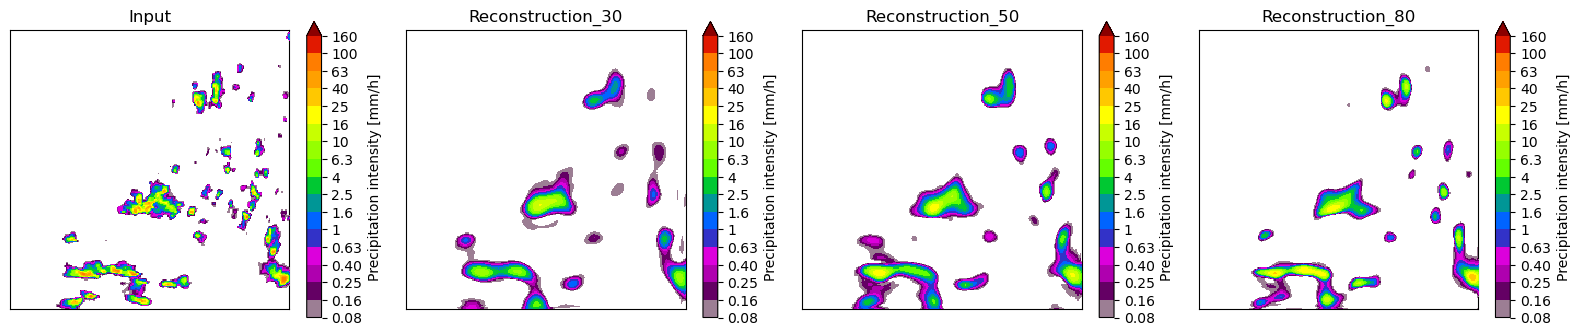

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 10.844 MAE: 0.459 PCC: 0.587 
 MSE: 9.299 MAE: 0.401 PCC: 0.612 
 MSE: 7.935 MAE: 0.378 PCC: 0.676 
 CSI(1mm): 0.41 CSI(2mm): 0.358 CSI(8mm): 0.153 
 ACC(1mm): 0.963 ACC(2mm): 0.972 ACC(8mm): 0.986 
 FSS(1km): 0.946 FSS(10km): 0.922 FSS(20km): 0.854 FSS(30km): 0.659 
 CSI(1mm): 0.492 CSI(2mm): 0.471 CSI(8mm): 0.4 
 ACC(1mm): 0.97 ACC(2mm): 0.977 ACC(8mm): 0.989 
 FSS(1km): 0.943 FSS(10km): 0.92 FSS(20km): 0.867 FSS(30km): 0.687 



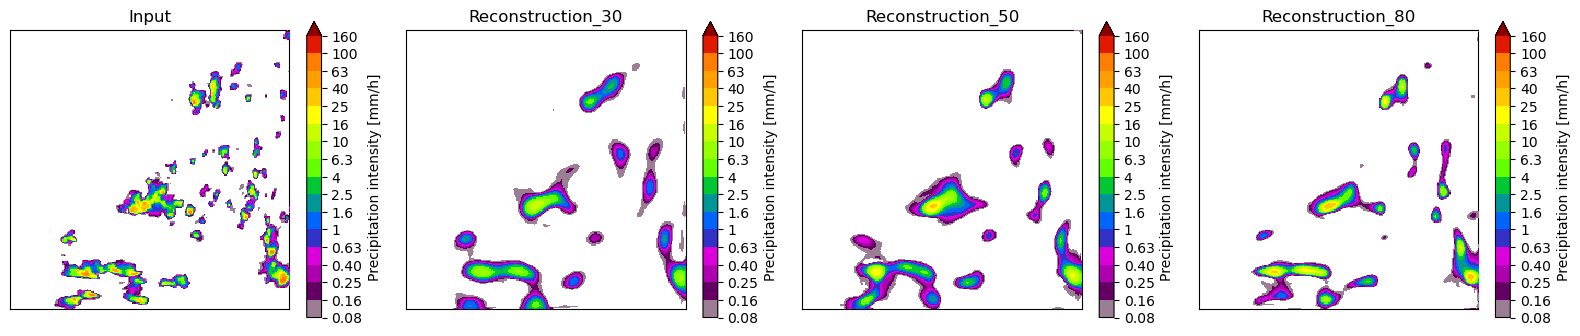

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 3.762 MAE: 0.351 PCC: 0.66 
 MSE: 3.326 MAE: 0.315 PCC: 0.717 
 MSE: 2.713 MAE: 0.291 PCC: 0.767 
 CSI(1mm): 0.641 CSI(2mm): 0.555 CSI(8mm): 0.2 
 ACC(1mm): 0.955 ACC(2mm): 0.967 ACC(8mm): 0.987 
 FSS(1km): 0.983 FSS(10km): 0.972 FSS(20km): 0.945 FSS(30km): 0.858 
 CSI(1mm): 0.672 CSI(2mm): 0.585 CSI(8mm): 0.381 
 ACC(1mm): 0.961 ACC(2mm): 0.97 ACC(8mm): 0.99 
 FSS(1km): 0.992 FSS(10km): 0.986 FSS(20km): 0.965 FSS(30km): 0.883 



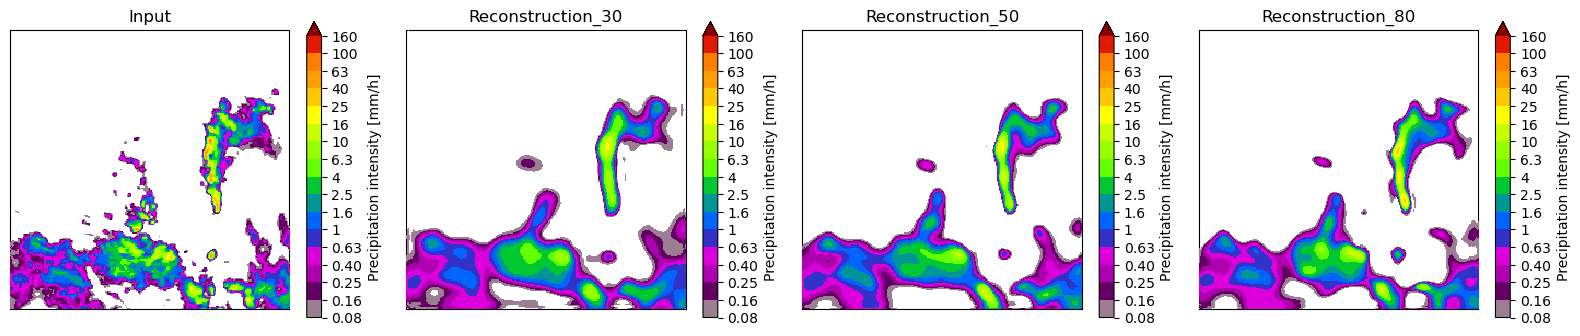

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 8.377 MAE: 0.411 PCC: 0.529 
 MSE: 7.86 MAE: 0.371 PCC: 0.577 
 MSE: 6.262 MAE: 0.338 PCC: 0.686 
 CSI(1mm): 0.443 CSI(2mm): 0.405 CSI(8mm): 0.068 
 ACC(1mm): 0.967 ACC(2mm): 0.975 ACC(8mm): 0.985 
 FSS(1km): 0.93 FSS(10km): 0.91 FSS(20km): 0.855 FSS(30km): 0.668 
 CSI(1mm): 0.521 CSI(2mm): 0.496 CSI(8mm): 0.38 
 ACC(1mm): 0.974 ACC(2mm): 0.979 ACC(8mm): 0.989 
 FSS(1km): 0.962 FSS(10km): 0.947 FSS(20km): 0.899 FSS(30km): 0.709 



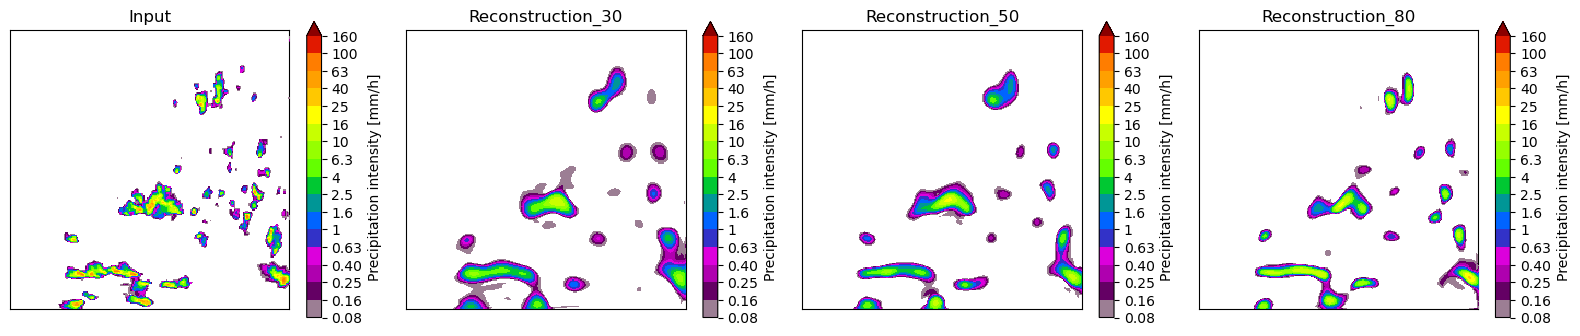

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 8.005 MAE: 0.382 PCC: 0.546 
 MSE: 7.021 MAE: 0.341 PCC: 0.649 
 MSE: 6.015 MAE: 0.321 PCC: 0.67 
 CSI(1mm): 0.422 CSI(2mm): 0.351 CSI(8mm): 0.048 
 ACC(1mm): 0.972 ACC(2mm): 0.976 ACC(8mm): 0.986 
 FSS(1km): 0.918 FSS(10km): 0.899 FSS(20km): 0.846 FSS(30km): 0.651 
 CSI(1mm): 0.492 CSI(2mm): 0.435 CSI(8mm): 0.344 
 ACC(1mm): 0.973 ACC(2mm): 0.978 ACC(8mm): 0.989 
 FSS(1km): 0.947 FSS(10km): 0.925 FSS(20km): 0.87 FSS(30km): 0.687 



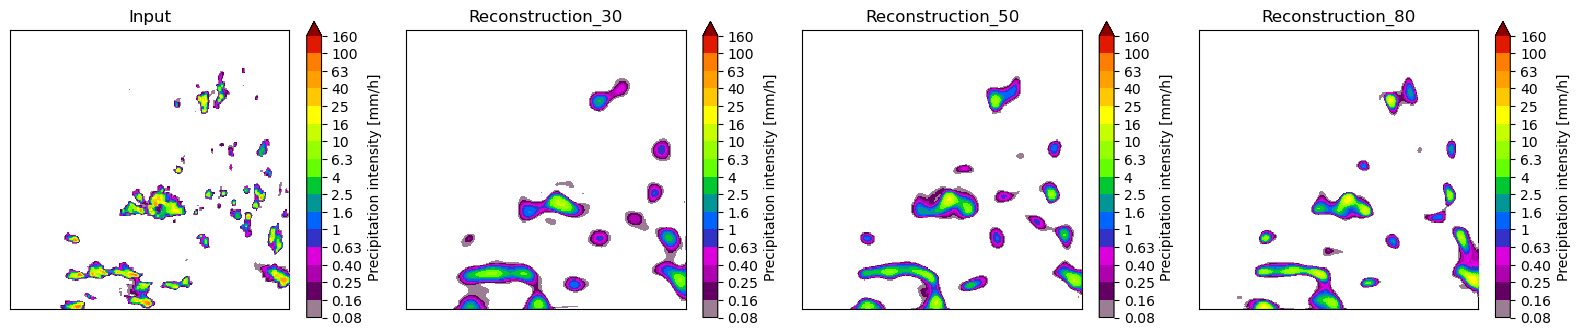

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 4.365 MAE: 0.349 PCC: 0.621 
 MSE: 3.966 MAE: 0.309 PCC: 0.674 
 MSE: 3.27 MAE: 0.3 PCC: 0.731 
 CSI(1mm): 0.64 CSI(2mm): 0.567 CSI(8mm): 0.23 
 ACC(1mm): 0.955 ACC(2mm): 0.967 ACC(8mm): 0.988 
 FSS(1km): 0.989 FSS(10km): 0.98 FSS(20km): 0.954 FSS(30km): 0.861 
 CSI(1mm): 0.668 CSI(2mm): 0.604 CSI(8mm): 0.398 
 ACC(1mm): 0.961 ACC(2mm): 0.971 ACC(8mm): 0.99 
 FSS(1km): 0.983 FSS(10km): 0.974 FSS(20km): 0.951 FSS(30km): 0.868 



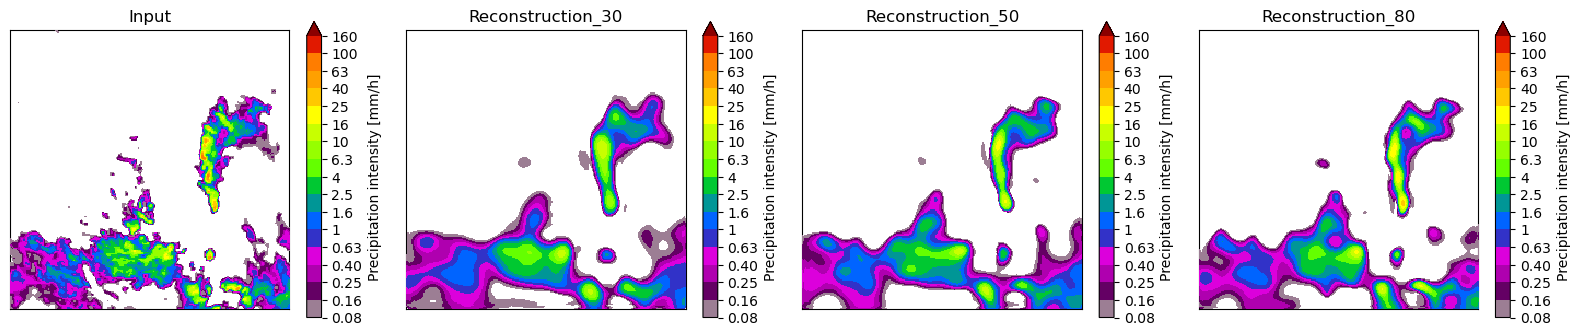

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 5.303 MAE: 0.381 PCC: 0.618 
 MSE: 4.652 MAE: 0.344 PCC: 0.697 
 MSE: 3.62 MAE: 0.317 PCC: 0.758 
 CSI(1mm): 0.611 CSI(2mm): 0.534 CSI(8mm): 0.203 
 ACC(1mm): 0.949 ACC(2mm): 0.966 ACC(8mm): 0.987 
 FSS(1km): 0.986 FSS(10km): 0.977 FSS(20km): 0.953 FSS(30km): 0.87 
 CSI(1mm): 0.674 CSI(2mm): 0.588 CSI(8mm): 0.369 
 ACC(1mm): 0.961 ACC(2mm): 0.971 ACC(8mm): 0.989 
 FSS(1km): 0.988 FSS(10km): 0.982 FSS(20km): 0.961 FSS(30km): 0.883 



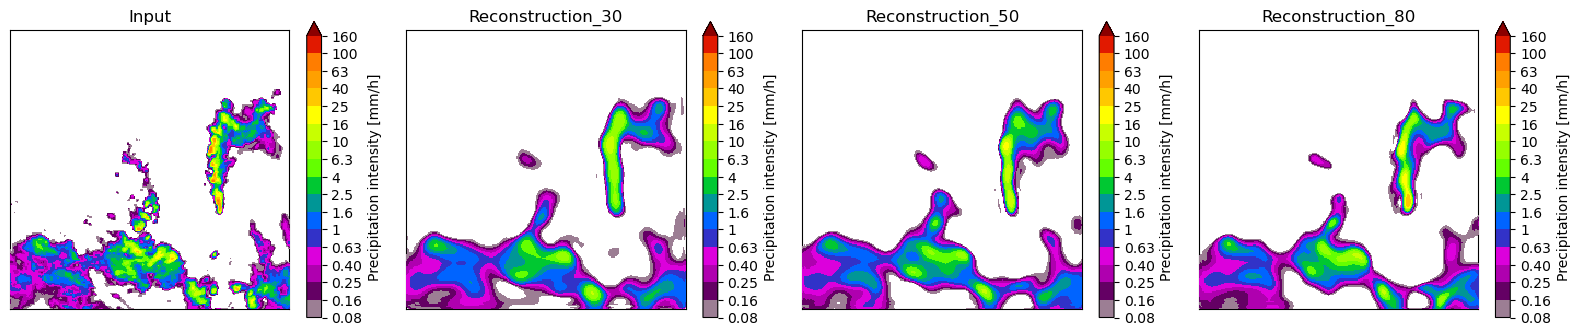

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 6.367 MAE: 0.328 PCC: 0.532 
 MSE: 5.969 MAE: 0.294 PCC: 0.614 
 MSE: 4.828 MAE: 0.274 PCC: 0.673 
 CSI(1mm): 0.409 CSI(2mm): 0.302 CSI(8mm): 0.155 
 ACC(1mm): 0.975 ACC(2mm): 0.978 ACC(8mm): 0.989 
 FSS(1km): 0.916 FSS(10km): 0.893 FSS(20km): 0.842 FSS(30km): 0.65 
 CSI(1mm): 0.502 CSI(2mm): 0.458 CSI(8mm): 0.311 
 ACC(1mm): 0.978 ACC(2mm): 0.982 ACC(8mm): 0.991 
 FSS(1km): 0.944 FSS(10km): 0.914 FSS(20km): 0.86 FSS(30km): 0.677 



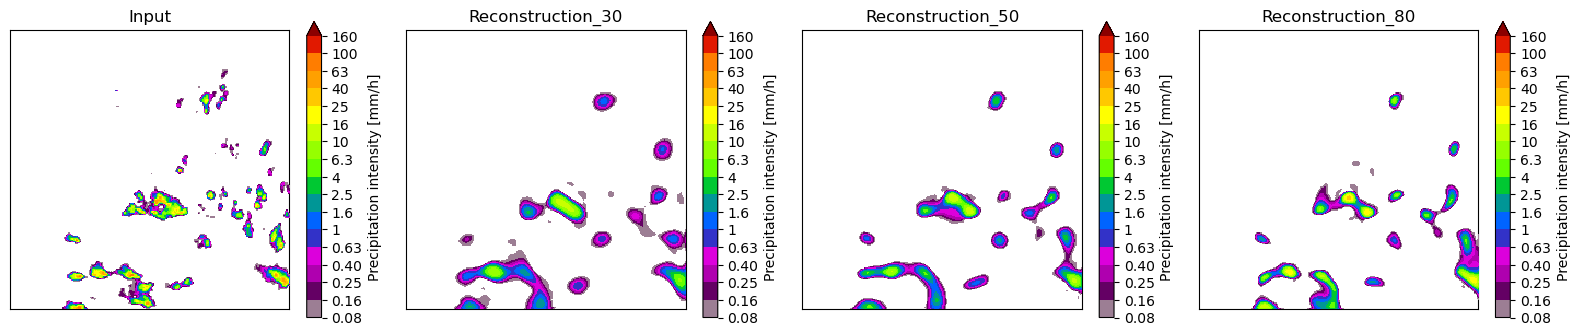

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 6.94 MAE: 0.299 PCC: 0.451 
 MSE: 6.314 MAE: 0.264 PCC: 0.565 
 MSE: 5.614 MAE: 0.243 PCC: 0.599 
 CSI(1mm): 0.379 CSI(2mm): 0.316 CSI(8mm): 0.143 
 ACC(1mm): 0.977 ACC(2mm): 0.982 ACC(8mm): 0.991 
 FSS(1km): 0.917 FSS(10km): 0.895 FSS(20km): 0.843 FSS(30km): 0.648 
 CSI(1mm): 0.484 CSI(2mm): 0.453 CSI(8mm): 0.317 
 ACC(1mm): 0.982 ACC(2mm): 0.986 ACC(8mm): 0.992 
 FSS(1km): 0.958 FSS(10km): 0.937 FSS(20km): 0.89 FSS(30km): 0.705 



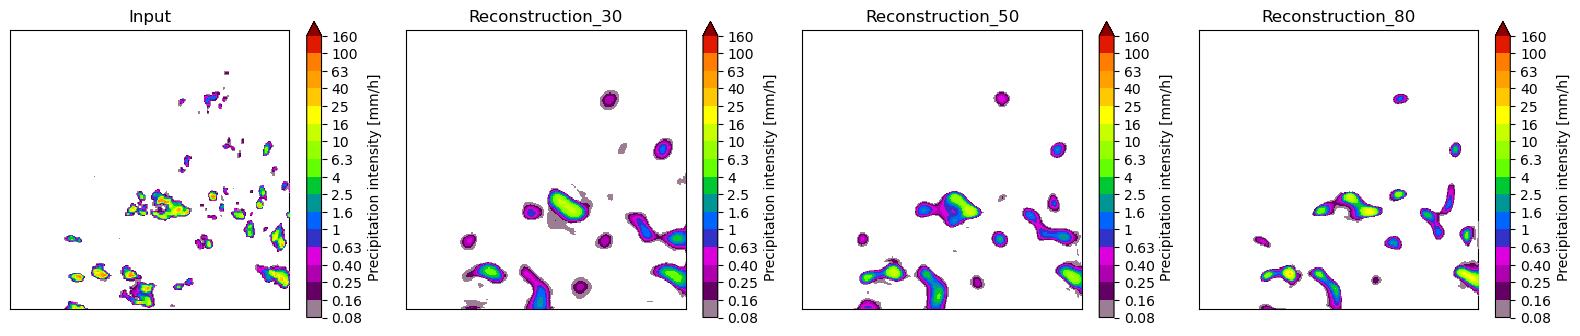

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 6.216 MAE: 0.27 PCC: 0.378 
 MSE: 5.759 MAE: 0.239 PCC: 0.511 
 MSE: 4.798 MAE: 0.214 PCC: 0.611 
 CSI(1mm): 0.397 CSI(2mm): 0.321 CSI(8mm): 0.099 
 ACC(1mm): 0.98 ACC(2mm): 0.983 ACC(8mm): 0.991 
 FSS(1km): 0.929 FSS(10km): 0.906 FSS(20km): 0.846 FSS(30km): 0.627 
 CSI(1mm): 0.527 CSI(2mm): 0.51 CSI(8mm): 0.339 
 ACC(1mm): 0.984 ACC(2mm): 0.987 ACC(8mm): 0.993 
 FSS(1km): 0.949 FSS(10km): 0.934 FSS(20km): 0.897 FSS(30km): 0.704 



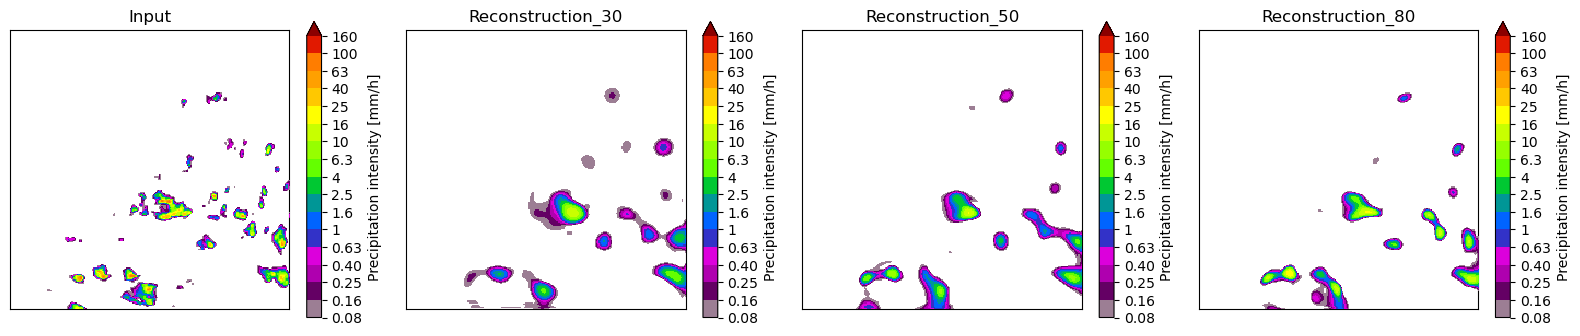

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 4.283 MAE: 0.224 PCC: 0.528 
 MSE: 3.688 MAE: 0.193 PCC: 0.62 
 MSE: 3.036 MAE: 0.174 PCC: 0.676 
 CSI(1mm): 0.374 CSI(2mm): 0.282 CSI(8mm): 0.027 
 ACC(1mm): 0.982 ACC(2mm): 0.985 ACC(8mm): 0.993 
 FSS(1km): 0.934 FSS(10km): 0.915 FSS(20km): 0.86 FSS(30km): 0.644 
 CSI(1mm): 0.549 CSI(2mm): 0.463 CSI(8mm): 0.322 
 ACC(1mm): 0.986 ACC(2mm): 0.987 ACC(8mm): 0.994 
 FSS(1km): 0.95 FSS(10km): 0.936 FSS(20km): 0.895 FSS(30km): 0.701 



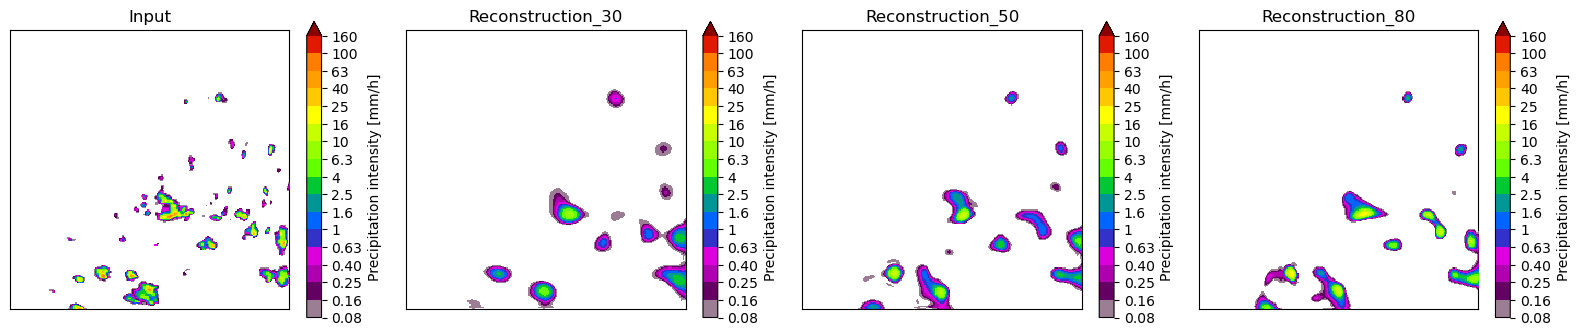

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 11.27 MAE: 0.459 PCC: 0.61 
 MSE: 9.274 MAE: 0.41 PCC: 0.655 
 MSE: 8.059 MAE: 0.379 PCC: 0.692 
 CSI(1mm): 0.439 CSI(2mm): 0.37 CSI(8mm): 0.166 
 ACC(1mm): 0.964 ACC(2mm): 0.972 ACC(8mm): 0.987 
 FSS(1km): 0.949 FSS(10km): 0.921 FSS(20km): 0.857 FSS(30km): 0.675 
 CSI(1mm): 0.509 CSI(2mm): 0.465 CSI(8mm): 0.384 
 ACC(1mm): 0.969 ACC(2mm): 0.975 ACC(8mm): 0.989 
 FSS(1km): 0.952 FSS(10km): 0.931 FSS(20km): 0.88 FSS(30km): 0.711 



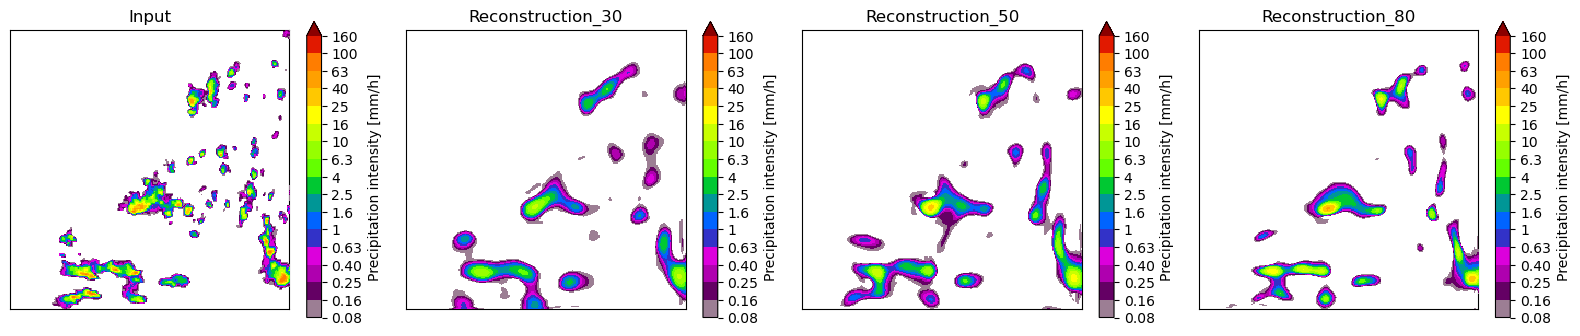

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 3.994 MAE: 0.338 PCC: 0.641 
 MSE: 3.316 MAE: 0.307 PCC: 0.705 
 MSE: 3.274 MAE: 0.296 PCC: 0.723 
 CSI(1mm): 0.649 CSI(2mm): 0.579 CSI(8mm): 0.157 
 ACC(1mm): 0.957 ACC(2mm): 0.969 ACC(8mm): 0.988 
 FSS(1km): 0.991 FSS(10km): 0.985 FSS(20km): 0.965 FSS(30km): 0.882 
 CSI(1mm): 0.685 CSI(2mm): 0.592 CSI(8mm): 0.33 
 ACC(1mm): 0.962 ACC(2mm): 0.97 ACC(8mm): 0.99 
 FSS(1km): 0.986 FSS(10km): 0.977 FSS(20km): 0.955 FSS(30km): 0.871 



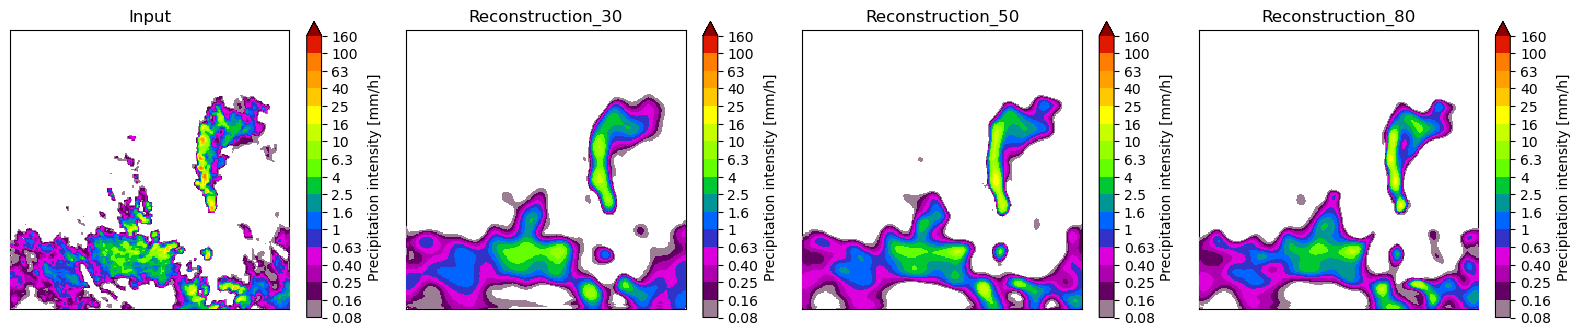

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 5.427 MAE: 0.373 PCC: 0.62 
 MSE: 4.687 MAE: 0.354 PCC: 0.669 
 MSE: 3.9 MAE: 0.313 PCC: 0.729 
 CSI(1mm): 0.616 CSI(2mm): 0.528 CSI(8mm): 0.106 
 ACC(1mm): 0.95 ACC(2mm): 0.966 ACC(8mm): 0.987 
 FSS(1km): 0.985 FSS(10km): 0.975 FSS(20km): 0.949 FSS(30km): 0.864 
 CSI(1mm): 0.633 CSI(2mm): 0.571 CSI(8mm): 0.382 
 ACC(1mm): 0.957 ACC(2mm): 0.97 ACC(8mm): 0.989 
 FSS(1km): 0.992 FSS(10km): 0.987 FSS(20km): 0.969 FSS(30km): 0.889 



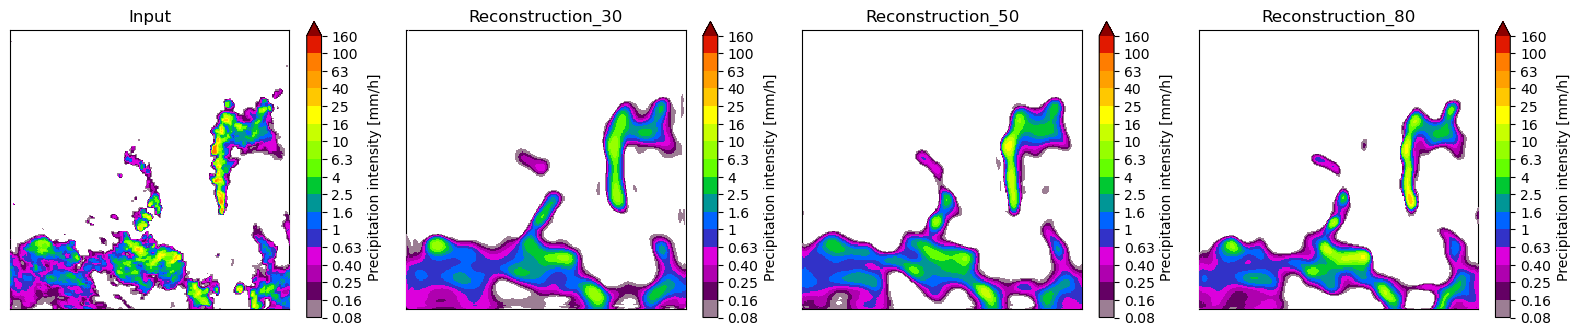

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 2.349 MAE: 0.168 PCC: 0.648 
 MSE: 1.865 MAE: 0.138 PCC: 0.731 
 MSE: 1.455 MAE: 0.123 PCC: 0.75 
 CSI(1mm): 0.344 CSI(2mm): 0.333 CSI(8mm): 0.055 
 ACC(1mm): 0.984 ACC(2mm): 0.989 ACC(8mm): 0.995 
 FSS(1km): 0.942 FSS(10km): 0.922 FSS(20km): 0.875 FSS(30km): 0.659 
 CSI(1mm): 0.488 CSI(2mm): 0.419 CSI(8mm): 0.316 
 ACC(1mm): 0.988 ACC(2mm): 0.99 ACC(8mm): 0.995 
 FSS(1km): 0.973 FSS(10km): 0.963 FSS(20km): 0.929 FSS(30km): 0.73 



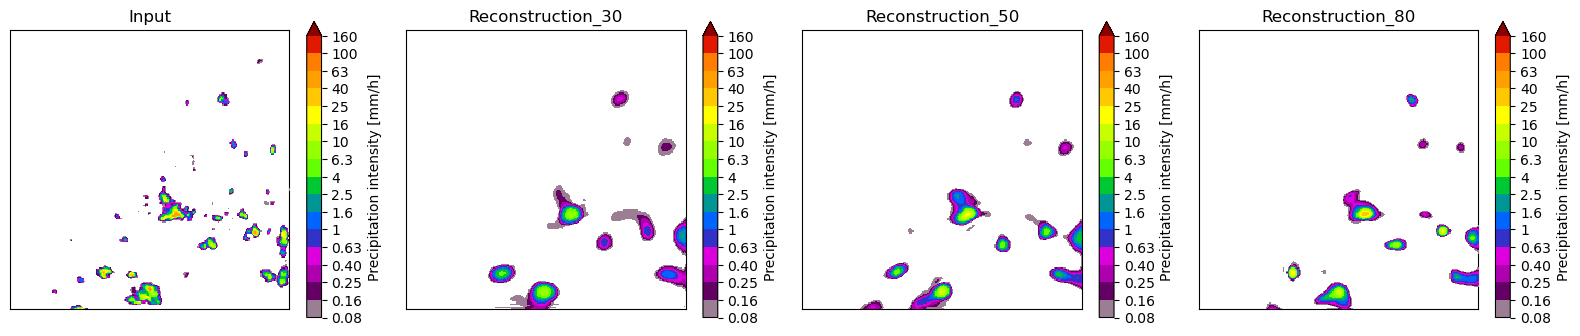

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 1.696 MAE: 0.139 PCC: 0.633 
 MSE: 1.279 MAE: 0.11 PCC: 0.706 
 MSE: 1.148 MAE: 0.097 PCC: 0.759 
 CSI(1mm): 0.397 CSI(2mm): 0.374 CSI(8mm): 0.082 
 ACC(1mm): 0.988 ACC(2mm): 0.991 ACC(8mm): 0.996 
 FSS(1km): 0.916 FSS(10km): 0.908 FSS(20km): 0.871 FSS(30km): 0.653 
 CSI(1mm): 0.544 CSI(2mm): 0.514 CSI(8mm): 0.313 
 ACC(1mm): 0.991 ACC(2mm): 0.993 ACC(8mm): 0.996 
 FSS(1km): 0.949 FSS(10km): 0.943 FSS(20km): 0.912 FSS(30km): 0.7 



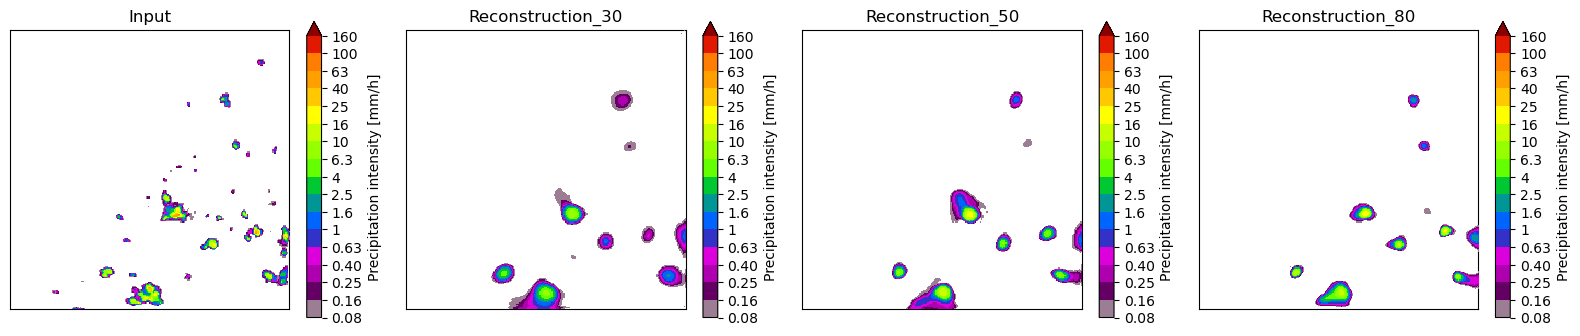

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])
MSE: 0.983 MAE: 0.106 PCC: 0.616 
 MSE: 0.837 MAE: 0.079 PCC: 0.641 
 MSE: 0.74 MAE: 0.072 PCC: 0.717 
 CSI(1mm): 0.461 CSI(2mm): 0.392 CSI(8mm): 0.0 
 ACC(1mm): 0.992 ACC(2mm): 0.994 ACC(8mm): 0.996 
 FSS(1km): 0.939 FSS(10km): 0.921 FSS(20km): 0.869 FSS(30km): 0.644 
 CSI(1mm): 0.545 CSI(2mm): 0.555 CSI(8mm): 0.233 
 ACC(1mm): 0.993 ACC(2mm): 0.995 ACC(8mm): 0.997 
 FSS(1km): 0.946 FSS(10km): 0.939 FSS(20km): 0.901 FSS(30km): 0.695 



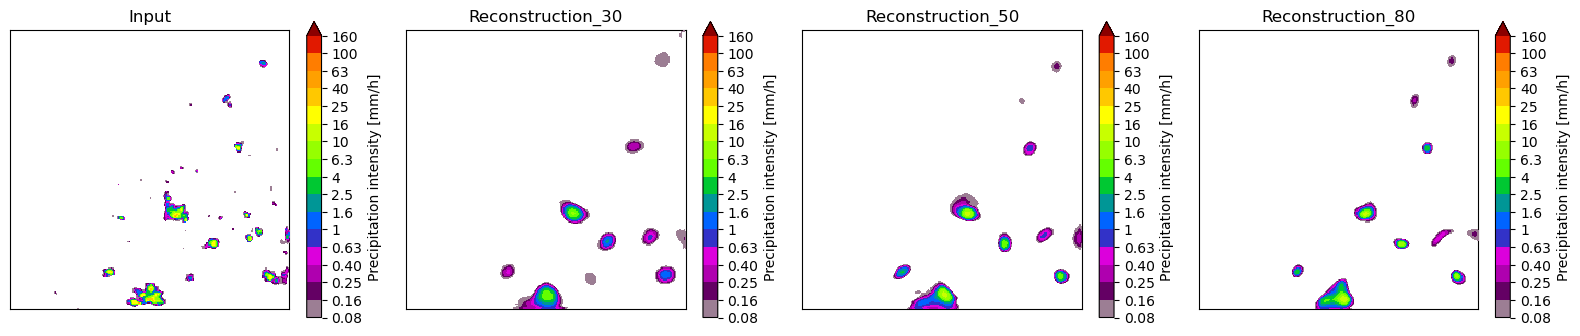

torch.Size([1, 9, 256, 256])
torch.Size([9, 256, 256])
torch.Size([9, 1, 256, 256])
torch.Size([9, 1, 256, 256])


KeyboardInterrupt: 

In [12]:
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cpu'
pcc_average = 0
pcc_average1 = 0
pcc_average2 = 0
for i, images in enumerate(loaders['test']):
    print(images.size())
    for image in images:
        print(image.size())
        image = image.unsqueeze(1)
        print(image.size())
        a = Variable(image).to(device)   # batch x
        print(a.size())
        vae = vae.to(device)
        #model1024 = model1024.to(device)
        #a = a[2:3, :, :, :]
        checkpoint = torch.load('/bulk/junzheyin/aaa/vae_epoch30', map_location = 'cpu')
        vae.load_state_dict(checkpoint, strict=True)
        a_r = vae(a)
        print(a_r.size())
        checkpoint = torch.load('/bulk/junzheyin/aaa/vae_epoch50', map_location = 'cpu')
        vae.load_state_dict(checkpoint, strict=True)
        a_r1 = vae(a)
        print(a_r1.size())
        checkpoint = torch.load('/bulk/junzheyin/aaa/vae_epoch80', map_location = 'cpu')
        vae.load_state_dict(checkpoint, strict=True)
        a_r2 = vae(a)
        print(a_r2.size())

        for t in range(1):
            #a_display = (a[t,0,:,:].to('cpu').detach().numpy()+1)/2*128
            #a_r_display = (a_r[t,0,:,:].to('cpu').detach().numpy()+1)/2*128
            a_display = a[t,0,:,:].to('cpu').detach().numpy()*40
            a_r_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
            a_r1_display = a_r1[t,0,:,:].to('cpu').detach().numpy()*40
            a_r2_display = a_r2[t,0,:,:].to('cpu').detach().numpy()*40
            
            #np.save('reconstruct_sample{}_gt'.format(i+1), a_display)
            #np.save('reconstruct_sample{}_vqgan1'.format(i+1), a_r_display)
            #np.save('reconstruct_sample{}_vqgan2'.format(i+1), a_r2_display)
            
            scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
            scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
            scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
            scores_cat12 = det_cat_fct(a_r2_display, a_display, 1)
            scores_cat22 = det_cat_fct(a_r2_display, a_display, 2)
            scores_cat82 = det_cat_fct(a_r2_display, a_display, 8)
            scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
            scores_cont2 = det_cont_fct(a_r1_display, a_display, thr=0.1)
            scores_cont3 = det_cont_fct(a_r2_display, a_display, thr=0.1)
            scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
            scores_spatial2 = intensity_scale(a_r2_display, a_display, 'FSS', 0.1, [1,10,20,30])
            pcc_average += float(np.around(scores_cont['corr_p'],3))
            pcc_average1 += float(np.around(scores_cont2['corr_p'],3))
            pcc_average2 += float(np.around(scores_cont3['corr_p'],3))
            if True:
                print('MSE:', np.around(scores_cont['MSE'],3), 
                      'MAE:', np.around(scores_cont['MAE'],3), 
                      'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                      'MSE:', np.around(scores_cont2['MSE'],3), 
                      'MAE:', np.around(scores_cont2['MAE'],3), 
                      'PCC:', np.around(scores_cont2['corr_p'],3),'\n',
                      'MSE:', np.around(scores_cont3['MSE'],3), 
                      'MAE:', np.around(scores_cont3['MAE'],3), 
                      'PCC:', np.around(scores_cont3['corr_p'],3),'\n',
                      'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                      'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                      'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                      'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                      'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                      'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                      'FSS(1km):', np.around(scores_spatial[0][0],3),
                      'FSS(10km):', np.around(scores_spatial[1][0],3),
                      'FSS(20km):', np.around(scores_spatial[2][0],3),
                      'FSS(30km):', np.around(scores_spatial[3][0],3),'\n',
                      'CSI(1mm):', np.around(scores_cat12['CSI'],3), # CSI: TP/(TP+FP+FN)
                      'CSI(2mm):', np.around(scores_cat22['CSI'],3),
                      'CSI(8mm):', np.around(scores_cat82['CSI'],3),'\n',
                      'ACC(1mm):', np.around(scores_cat12['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                      'ACC(2mm):', np.around(scores_cat22['ACC'],3),
                      'ACC(8mm):', np.around(scores_cat82['ACC'],3),'\n',
                      'FSS(1km):', np.around(scores_spatial2[0][0],3),
                      'FSS(10km):', np.around(scores_spatial2[1][0],3),
                      'FSS(20km):', np.around(scores_spatial2[2][0],3),
                      'FSS(30km):', np.around(scores_spatial2[3][0],3),'\n',
                     )  
                plt.figure(figsize=(16,4))
                plt.subplot(141)
                plot_precip_field(a_display, title="Input")
                plt.subplot(142)
                plot_precip_field(a_r_display, title="Reconstruction_30")
                plt.subplot(143)
                plot_precip_field(a_r1_display, title="Reconstruction_50")
                plt.subplot(144)
                plot_precip_field(a_r2_display, title="Reconstruction_80")
                plt.tight_layout()
                plt.show()
print('pcc_average:', pcc_average/i)
print('pcc_average1:', pcc_average1/i)
print('pcc_average2:', pcc_average2/i)